# Rachel's Spotify Data Analysis

Author: Rachel Tong 

linkedin.com/in/rachelwtong

This analysis makes use of my personal Spotify streaming data which Spotify allows all users to request. The goal of this analysis is to understand my own streaming behavior and song preferences by also leveraging the Spotify Web API data which contains audio characteristics of songs. This  <a href='https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject'>dataset from Kaggle</a> is used as the source for the Spotify Web API data.

## Notebook Set Up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from rapidfuzz import fuzz, process
from scipy.stats import ttest_ind

#Display values in float format 
pd.options.display.float_format = '{:.2f}'.format

#set sns settings 
sns.set_palette('viridis')
display(sns.color_palette(palette='viridis'))
print(sns.color_palette(palette='viridis').as_hex())

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

['#46327e', '#365c8d', '#277f8e', '#1fa187', '#4ac16d', '#a0da39']


In [4]:
#Set Directory
directory = os.getcwd()
os.chdir(directory)

In [5]:
#Rachel's Streaming History 
file = 'StreamingHistory0.json'
file2 = 'StreamingHistory1.json'
stream = pd.read_json(file)
stream2 = pd.read_json(file2)

#Merge the two streaming history files
stream = pd.concat([stream, stream2], axis=0)

In [6]:
stream.head(5)

,endTime,artistName,trackName,msPlayed
0,2022-10-03 01:52,BIBI,Animal Farm,278
1,2022-10-03 01:52,Pablo Arellano Music,SPA Music - 4 hours of beautiful Harp relaxing...,1155448
2,2022-10-03 01:55,BIBI,Animal Farm,203945
3,2022-10-03 01:58,Crush,Rush Hour (Feat. j-hope of BTS),177302
4,2022-10-03 02:02,Woo,Ghosting (Prod. CODE KUNST),220693


In [8]:
#Spotify Tracks Data 
tracks = pd.read_csv('spotify_dataset.csv')

In [7]:
tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.68,0.46,...,-6.75,0,0.14,0.03,0.00,0.36,0.71,87.92,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.42,0.17,...,-17.23,1,0.08,0.92,0.00,0.10,0.27,77.49,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.44,0.36,...,-9.73,1,0.06,0.21,0.00,0.12,0.12,76.33,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.27,0.06,...,-18.52,1,0.04,0.91,0.00,0.13,0.14,181.74,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.62,0.44,...,-9.68,1,0.05,0.47,0.00,0.08,0.17,119.95,4,acoustic


## Data Cleaning

### stream dataset cleaning

In [8]:
#Convert endTime to datetime column 
stream['endTime'] = pd.to_datetime(stream['endTime'])

#Add date columns 
stream['m_yr'] = stream['endTime'].dt.to_period('M')

#Add minutes played column 
stream['minPlayed'] = stream['msPlayed']/60000

#to increase match rate with spotify dataset, all artist names and track names will be coverted to lowercase
stream['artistName'] = stream['artistName'].str.lower().astype(str)
stream['trackName'] = stream['trackName'].str.lower().astype(str)

#artistName + trackName for easy indexing 
stream['key'] = stream['artistName'] + ' '+ stream['trackName']

### tracks dataset cleaning

In [9]:
#Add minutes played column
tracks['minPlayed'] = tracks['duration_ms']/60000

#convert artist names and track names to lowercase
tracks['artists'] = tracks['artists'].str.lower().astype(str)
tracks['track_name'] = tracks['track_name'].str.lower().astype(str)

tracks['key'] = tracks['artists'] + ' '+ tracks['track_name']

### merging the streams and tracks datasets pose a challenge due to slight differences between track and artist names. We can use the rapid library to perform similarity matching between the two datasets on the "key" variable

In [12]:
# Create a dictionary to map variables in stream to the best matching variables  in track
threshold=85

key_mapping = {key1: process.extractOne(key1, tracks['key'].unique(), scorer=fuzz.ratio, score_cutoff=threshold) for key1 in stream['key'].unique()}

In [13]:
# Create a DataFrame from the key mapping dictionary
mapped_keys = pd.DataFrame(key_mapping).T.rename(columns={0: 'Best_Match', 1: 'Similarity_Score'})
mapped_keys = mapped_keys[mapped_keys['Similarity_Score'] >= threshold]
mapped_keys.reset_index(inplace=True)
mapped_keys.head()

,index,Best_Match,Similarity_Score,2
0,bibi animal farm,bibi animal farm,100.00,50333
1,crush rush hour (feat. j-hope of bts),crush;j-hope rush hour (feat. j-hope of bts),91.36,49567
2,junny by my side,junny by my side,100.00,13189
3,jimmy brown irene,jimmy brown irene,100.00,13715
4,slchld you won't be there for me,slchld you won't be there for me,100.00,13389


In [15]:
#add the identified matched variable to the tracks dataset
tracks_key = tracks.merge(mapped_keys, how='left',left_on='key',right_on='Best_Match')

# Merge the DataFrames based on the mapped names
result = pd.merge(stream, tracks_key, how='left', left_on='key', right_on='index', suffixes=['_s','_t'])


In [16]:
result.sample(5)

,endTime,artistName,trackName,msPlayed,m_yr,minPlayed_s,key_s,Unnamed: 0,track_id,artists,...,liveness,valence,tempo,time_signature,track_genre,minPlayed_t,index,Best_Match,Similarity_Score,2
15406,2023-09-21 12:57:00,code kunst,"dirt in my head (feat. car, the garden)",185969,2023-09,3.10,"code kunst dirt in my head (feat. car, the gar...",nan,NaN,NaN,...,nan,nan,nan,nan,NaN,nan,NaN,NaN,NaN,NaN
6034,2023-02-15 15:14:00,itzy,shoot!,139178,2023-02,2.32,itzy shoot!,65418.00,2xeaHUnzzT5Kc974OQt1kA,itzy,...,0.16,0.91,131.96,4.00,k-pop,2.32,itzy shoot!,itzy shoot!,100.00,49914
9664,2023-05-30 01:09:00,exo,ko ko bop,190422,2023-05,3.17,exo ko ko bop,65804.00,5EzitieoPnjyKHAq0gfRMa,exo,...,0.07,0.67,145.98,4.00,k-pop,3.17,exo ko ko bop,exo ko ko bop,100.00,50243
12704,2023-08-05 18:01:00,jay park,dank,198949,2023-08,3.32,jay park dank,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,nan,NaN,NaN,NaN,NaN
15027,2023-09-13 19:57:00,olivia rodrigo,making the bed,198831,2023-09,3.31,olivia rodrigo making the bed,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,nan,NaN,NaN,NaN,NaN


## limitations of this methodology

- Matching similar artist/track pairs across the two datasets is challenging due to the small differences in how the names are recorded. 
- Having the current similarity threshold ensures that we are capturing matches that have these differences. However, a manual check also indicates that a threshold of 85 currently allows the possibility of different tracks with the same artist to be matched (type 1 error). 
- The match on both artist and track also limits the final number of successful matches 
- To further improve this process in the future, the threshold can be treated as a hyperparameter and tuned to reduce type 1 error. 
- For the purposes of this analysis, only the subset of tracks that are matched between the stream and tracks datasets will be used for further exploration

In [17]:
#create subset from results dataset where tracks were successfully matched between the two datasets
matched_df = result[result['index'].notnull()]

In [18]:
#Compare differences between high level stats across datasets
def df_summary(df1, df_name):

    df1_songs = df1['trackName'].nunique()
    df1_top10songs = df1['trackName'].value_counts().nlargest(10)
    df1_top10artists = df1['artistName'].value_counts().nlargest(10)
    
    print(df_name, 'Summary \n')
    print('Number of Unique Songs:\n',df1_songs)
    print('\n Top 10 Songs and # of Times Streamed: \n', df1_top10songs)
    print('\n Top 10 Artists and # of Times Streamed: \n', df1_top10artists)    

In [19]:
df_summary(stream, 'stream')

stream Summary 

Number of Unique Songs:
 3786

 Top 10 Songs and # of Times Streamed: 
 ghosting (prod. code kunst)                  44
attention                                    38
queencard                                    37
get it                                       36
allergy                                      35
unknown track                                34
what it is (block boy) (with kodak black)    33
trippin'                                     31
年轮                                           31
cheshire                                     31
Name: trackName, dtype: int64

 Top 10 Artists and # of Times Streamed: 
 keshi            375
taylor swift     307
bts              243
bibi             227
blackpink        213
ariana grande    207
aespa            196
nct 127          185
newjeans         184
(g)i-dle         158
Name: artistName, dtype: int64


In [20]:
df_summary(matched_df, 'Matched Dataset')

Matched Dataset Summary 

Number of Unique Songs:
 773

 Top 10 Songs and # of Times Streamed: 
 heat waves                                           986
the business                                         125
i feel good                                          102
love me like you do - from "fifty shades of grey"     76
somewhere only we know                                72
pink venom                                            64
shut down                                             60
vienna                                                60
nothing feels better                                  60
double take                                           56
Name: trackName, dtype: int64

 Top 10 Artists and # of Times Streamed: 
 glass animals    988
bts              436
blackpink        366
keshi            352
pink sweat$      222
ariana grande    148
martin garrix    135
tiësto           125
khalil fong       86
jay chou          81
Name: artistName, dtype: int64


While the matched table contains only ~24% of the songs from my past year's streaming history, based on the comparison of the top 10 artists and songs, there is still a good representation of my top songs and listening preferences to form the foundation of the subsequent exploratory analysis.

## Exploratory Data Analysis

In [21]:
#Create datasets for different analyses and aggregation 

#Clean matched_df and remove unnecessary/duplicate columns 
drop_columns=['Unnamed: 0','track_id','artists','trackName','key_t','minPlayed_t','index','Best_Match','Similarity_Score',2]
matched_df = matched_df.drop(columns=drop_columns)

#Create dataset with unique songs only with aggregated streaming stats and audio characteristics
unique_songs = matched_df.groupby('key_s')[['key_s','minPlayed_s']].agg(num_played=('key_s','count'),min_played=('minPlayed_s','sum')).reset_index()
matched_df_clean = matched_df.drop_duplicates(subset='key_s')
unique_songs = pd.merge(unique_songs, matched_df_clean, how='left',on='key_s')

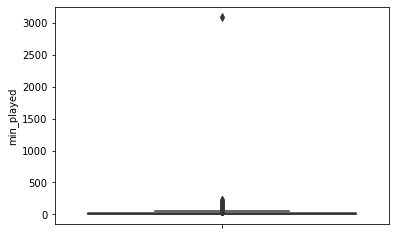

In [22]:
#check outliers
sns.boxplot(y='min_played',data=unique_songs)
plt.show()

In [23]:
unique_songs[unique_songs['min_played'] > 500]

,key_s,num_played,min_played,endTime,artistName,msPlayed,m_yr,minPlayed_s,album_name,track_name,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
325,glass animals heat waves,986,3094.81,2022-10-29 00:28:00,glass animals,238769,2022-10,3.98,Heat Waves,heat waves,...,-6.90,1.00,0.09,0.44,0.00,0.09,0.53,80.87,4.00,indie-pop


In [24]:
unique_songs.drop(index=325,axis=0,inplace=True)

### 1. Top Music Genres

In [25]:
def bar_plot(data_x, data_y, agg, df, x_label, y_label, title):
    
    plot = df.groupby(data_x)[data_y].agg(agg).nlargest(10).reset_index()
    
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=data_x, y=data_y, data=plot)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()

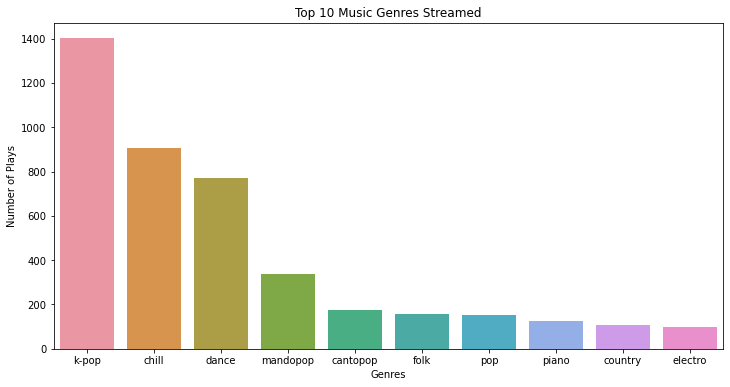

In [26]:
genre_10_tracks = unique_songs.groupby('track_genre')['num_played'].sum().nlargest(10).reset_index()
    
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='track_genre', y='num_played', data=genre_10_tracks)

plt.xlabel('Genres')
plt.ylabel('Number of Plays')
plt.title('Top 10 Music Genres Streamed')
    
plt.show()

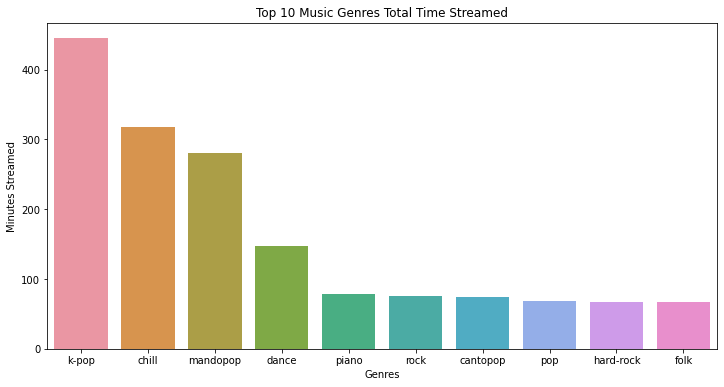

In [27]:
bar_plot('track_genre','minPlayed_s', 'sum', unique_songs, 'Genres','Minutes Streamed', 'Top 10 Music Genres Total Time Streamed')

k-pop and chill are the top 2 genres based on number of songs played and total minutes streamed.

### 2. Analyze Popularity of Songs

In [28]:
top_10_genre = unique_songs['track_genre'].value_counts().nlargest(10).reset_index()['index']
top_10_genre = list(top_10_genre)
top_10_genre 

['k-pop',
 'chill',
 'mandopop',
 'dance',
 'pop',
 'cantopop',
 'piano',
 'folk',
 'rock',
 'hard-rock']

In [29]:
top_50_songs = unique_songs['track_name'].value_counts().nlargest(50).reset_index()['index']
top_50_songs = list(top_50_songs)

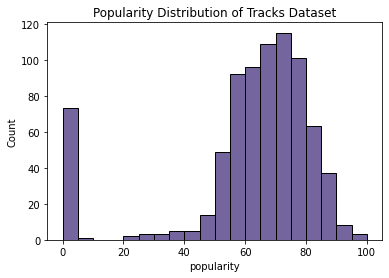

In [32]:
sns.histplot(x='popularity',data=unique_songs,bins=20)
plt.title('Popularity Distribution of Tracks Dataset')
plt.show()

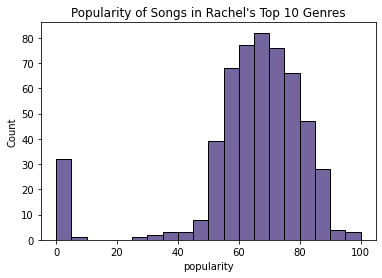

In [34]:
sns.histplot(x='popularity',data=unique_songs[unique_songs['track_genre'].isin(top_10_genre)],bins=20)
plt.title("Popularity of Songs in Rachel's Top 10 Genres")
plt.show()

- The popularity of songs in my top 10 genres are distributed simiilarly to the entire dataset

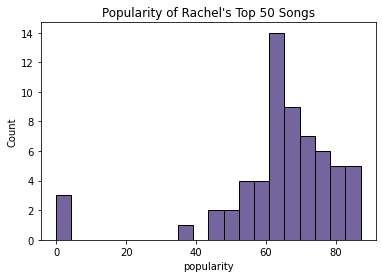

In [36]:
sns.histplot(x='popularity',data=unique_songs[unique_songs['track_name'].isin(top_50_songs)],bins=20)
plt.title("Popularity of Rachel's Top 50 Songs")
plt.show()

- The popularity distribution of my top 50 songs is in the higher range compared to distribution of the entire dataset. My top songs are likely influenced by what is popular at the moment and aligned more closely with what the general public enjoys listening to
- There are six songs in my top 50 that have popularity scores less than 10

In [37]:
unique_songs[(unique_songs['track_name'].isin(top_50_songs)) & (unique_songs['popularity']<10)][['track_name','popularity']]

,track_name,popularity
299,little lies - 2018 remaster,3.00
525,reminiscing - remastered,2.00
712,iris,0.00


In [38]:
#create dataset with just top50 songs
top50_df = unique_songs[unique_songs['track_name'].isin(top_50_songs)]

### 3. Analyze Audio Characteristics

In [39]:
audio_char = ['popularity', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness',
       'liveness', 'valence', 'tempo']

def df_audio_summary(df):
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
    axes=axes.flatten()

    # Plot frequency distribution for each variable using Seaborn
    for i, col in enumerate(df[audio_char]):
        ax = axes[i]
        sns.histplot(df[col], bins=10, ax=ax, kde=True)
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
        mean_value = df[col].mean()
        
        ax.text(0.1, 0.9, f'Mean: {mean_value:.2f}', transform=ax.transAxes, fontsize=12, color='red')
    
    plt.tight_layout()
    plt.show()

### Rachel's Top 50 Audio Characteristics

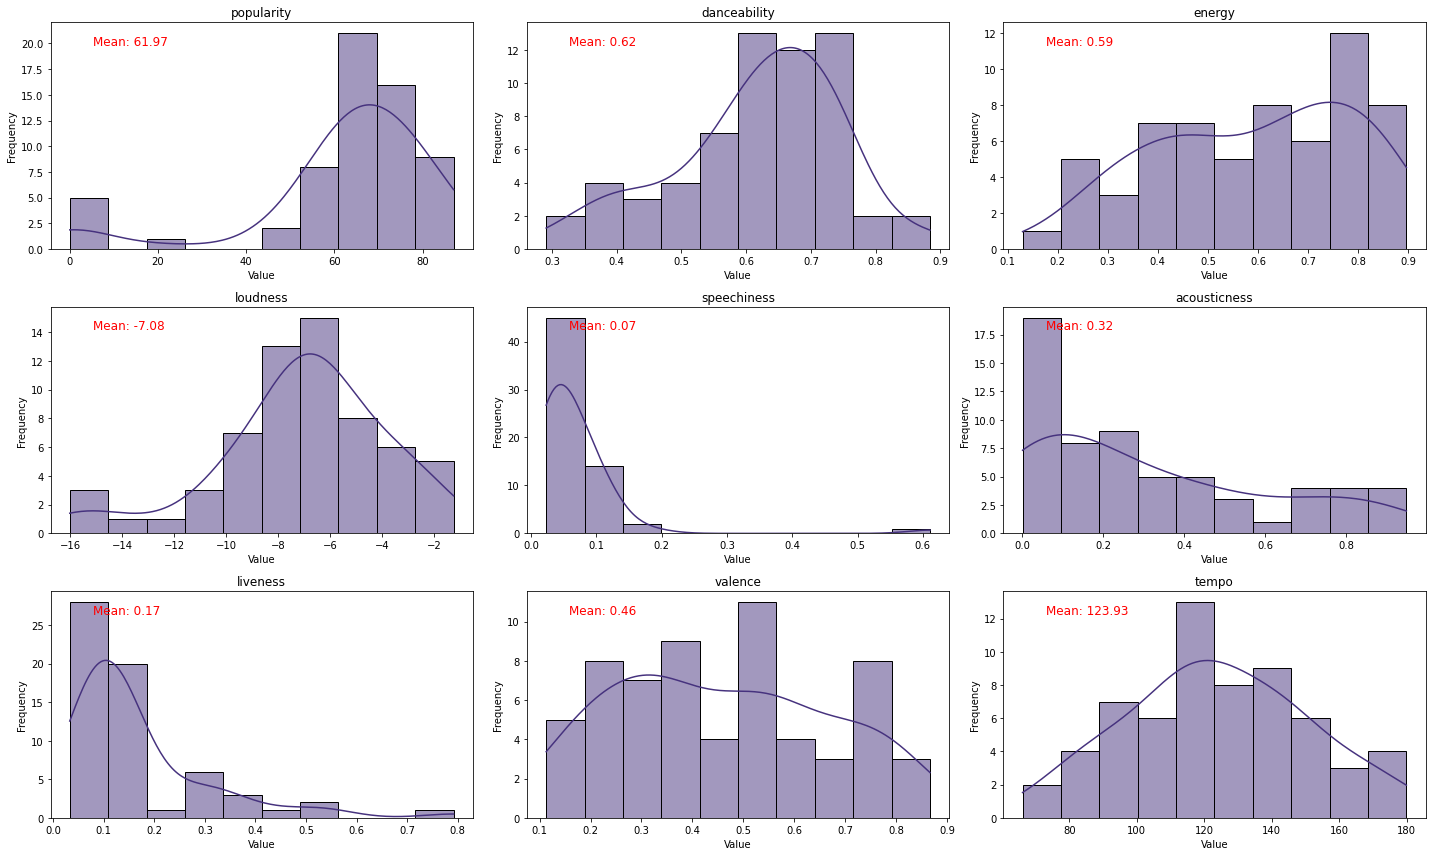

In [148]:
df_audio_summary(top50_df)

### Spotify Tracks Audio Characteristics

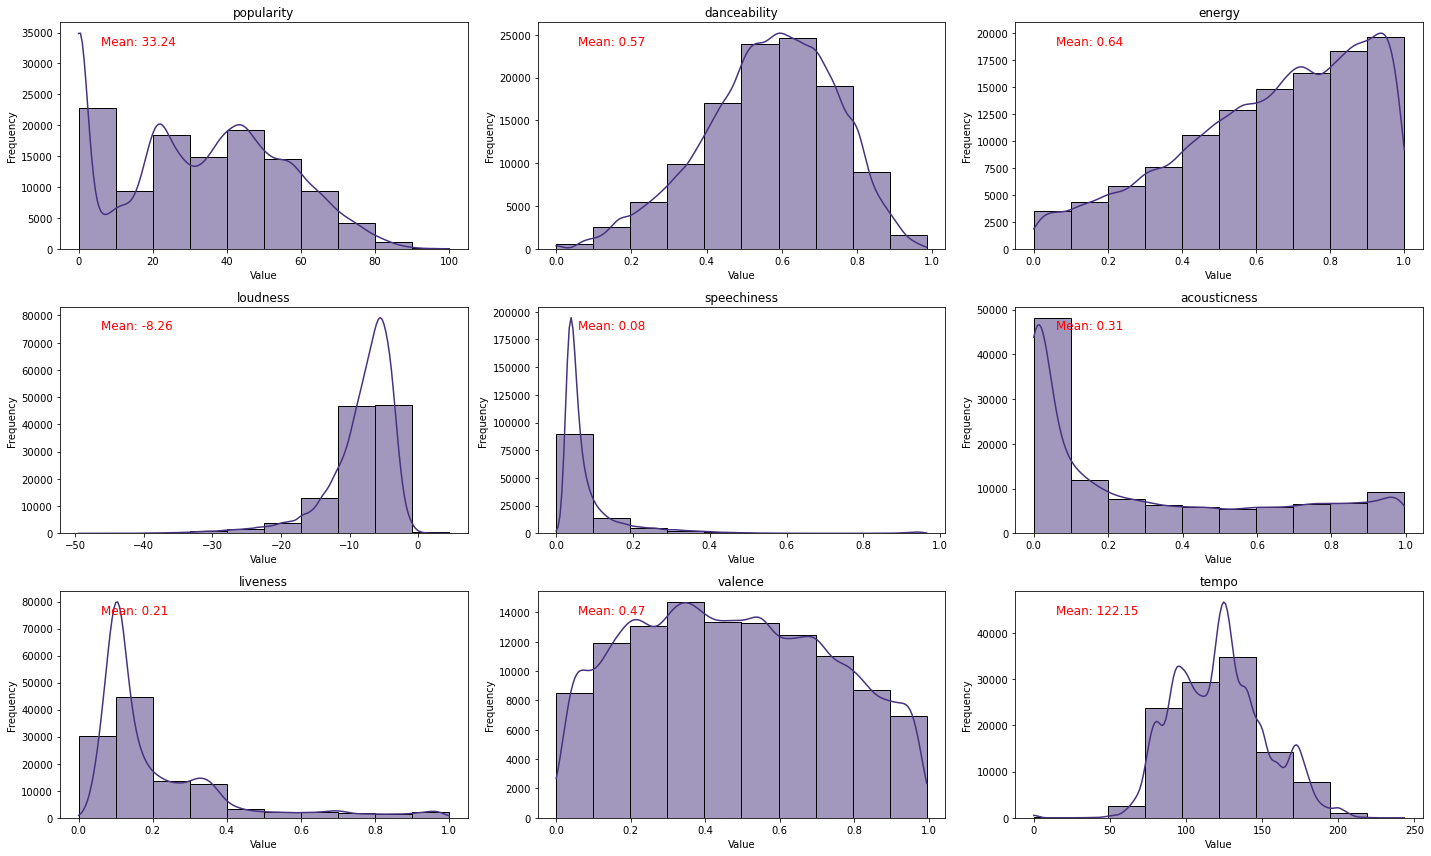

In [149]:
df_audio_summary(tracks)

In [167]:
#Use t-test to evaluate statistical significance of the difference in my top 50 compared to the entire tracks dataset. 

def stat_difference (df1, df2, characteristics):
    
    result = pd.DataFrame(columns=['Characteristic',"Rachel's Top 50", 'Spotify Tracks','p_value','Stat_Difference'])
    index = 0
    
    for i in characteristics: 
        stat, p_value =ttest_ind(df1[i], df2[i]) 
        
        if p_value <= 0.05:
            stat_diff = 'Significant'
        else:
            stat_diff = 'Insignificant'
        
        index = index+1 
        
        #new_row = pd.DataFrame({'Characteristic':i, "Rachel's Top 50":df1[i].mean(),"Spotify Tracks": df2[i].mean(),"p_value":p_value, "Stat_Difference":stat_diff})
        new_row = [i,df1[i].mean(),df2[i].mean(),p_value,stat_diff]
        result.loc[index] = new_row
        
    return result


In [168]:
stat_difference(top50_df,tracks,audio_char)

,Characteristic,Rachel's Top 50,Spotify Tracks,p_value,Stat_Difference
1,popularity,61.94,33.24,0.00,Significant
2,danceability,0.62,0.57,0.01,Significant
3,energy,0.60,0.64,0.15,Insignificant
4,loudness,-7.13,-8.26,0.08,Insignificant
5,speechiness,0.08,0.08,0.49,Insignificant
6,acousticness,0.30,0.31,0.76,Insignificant
7,liveness,0.16,0.21,0.04,Significant
8,valence,0.46,0.47,0.65,Insignificant
9,tempo,124.89,122.15,0.47,Insignificant


- Based on graphical analysis and significance test, meaningful differences in my top 50's mean popularity and danceability can be observed compared to the Spotify Tracks database. Specifically, songs in my top5 have much higher mean popularity. I can also observe a preference for higher danceability and liveness score songs in my top 50 compared to the average danceability of songs in general. Liveness refers to probability the score was recorded wiht a live audience. This tells me that based on my listening, I am listening to songs that are less likely to be recorded in front of an audience compared to the average song in the tracks dataset. 